In [1]:
# Genetic algorithm hyperparameters
population_size = 20
num_generations = 20
num_best_to_select = 4
num_elite_individuals = 2
mutation_probability = 0.2  # Increased mutation rate for more diversity
num_evaluation_episodes = 100  # Number of episodes for evaluation
max_steps_per_episode = 100  # Max steps per episode

# Q-learning hyperparameters
learning_rate = 0.1
discount_factor = 0.99
initial_epsilon = 1.0
epsilon_decay_rate = 0.98  # Slower epsilon decay for more exploration
minimum_epsilon = 0.1  # Higher minimum epsilon to ensure continued exploration
num_q_learning_episodes = 200

Episode: 50/200, Total Reward: -156
Episode: 100/200, Total Reward: -91
Episode: 150/200, Total Reward: -1
Episode: 200/200, Total Reward: 6
List of Scores:
[-129.88, -129.43, -128.53, -128.8, -128.44, -127.0, -127.99, -126.91, -127.27, -125.65, -127.36, -127.54, -127.9, -126.82, -127.0, -127.0, -127.63, -125.65, -127.54, -127.27]


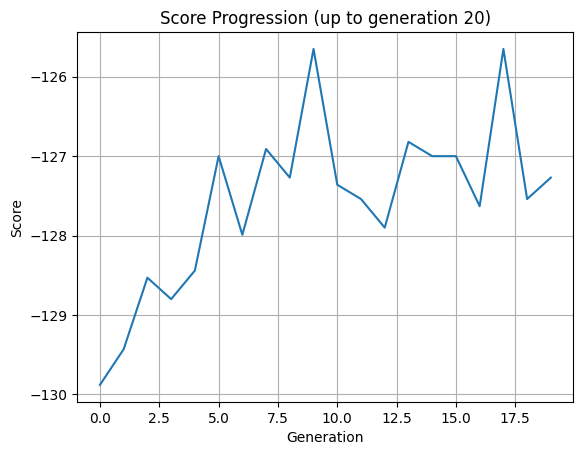

In [2]:
import subprocess
import sys
import os

# Function to install necessary Python packages
def install_package(package_name):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# Ensure necessary packages are installed
required_packages = ['gymnasium', 'numpy', 'matplotlib', 'pandas', 'fpdf']
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        install_package(package)

import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import functools

# Create the results directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# Create Taxi environment
env = gym.make('Taxi-v3')
env.reset(seed=123)

# Function to convert state tuple to integer
def convert_state_tuple_to_int(state) -> int:
    if isinstance(state, tuple):
        if isinstance(state[-1], dict):
            return functools.reduce(lambda acc, elem: acc * 10 + elem, state[:-1])
        else:
            return functools.reduce(lambda acc, elem: acc * 10 + elem, state)
    else:
        return state

# Initialize a population of Q-tables
state_space_size = env.observation_space.n
action_space_size = env.action_space.n

def create_initial_population(pop_size):
    return [np.random.uniform(low=-1, high=1, size=(state_space_size, action_space_size)) for _ in range(pop_size)]

def evaluate_qtable_performance(qtable, epsilon=0.1):
    total_reward = 0
    for _ in range(num_evaluation_episodes):
        state, _ = env.reset(seed=123)
        state = convert_state_tuple_to_int(state)
        done = False
        for _ in range(max_steps_per_episode):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(qtable[state, :])  # Exploit
            new_state, reward, done, _, _ = env.step(action)
            new_state = convert_state_tuple_to_int(new_state)
            total_reward += reward
            state = new_state
            if done:
                break
    return total_reward / num_evaluation_episodes

def select_best_individuals(population, num_best):
    performance_scores = [(qtable, evaluate_qtable_performance(qtable)) for qtable in population]
    performance_scores.sort(key=lambda x: x[1], reverse=True)
    best_individuals = [qtable for qtable, _ in performance_scores[:num_best]]
    best_scores = [score for _, score in performance_scores[:num_best]]
    return best_individuals, best_scores

def perform_crossover(parent1, parent2):
    child1, child2 = np.copy(parent1), np.copy(parent2)
    for i in range(parent1.shape[0]):
        if random.uniform(0, 1) > 0.5:
            child1[i, :], child2[i, :] = parent2[i, :], parent1[i, :]
    return child1, child2

def apply_mutation(qtable, mutation_probability):
    for i in range(qtable.shape[0]):
        for j in range(qtable.shape[1]):
            if random.uniform(0, 1) < mutation_probability:
                qtable[i, j] += np.random.randn() * 0.1

population = create_initial_population(population_size)
score_history = []

# Prepare PDF file for output
pdf = PdfPages('results/genetic_algorithm_reinforcement_learning_plots.pdf')

# Genetic algorithm training
plt.ion()
fig, ax = plt.subplots()
for generation in range(num_generations):
    best_qtables, best_scores = select_best_individuals(population, num_best_to_select)
    
    # Record the best performance
    best_score = best_scores[0]
    score_history.append(best_score)
    
    # Print the current generation and its best score
    print(f"Generation: {generation+1}/{num_generations}, Best Score: {best_score}")

    # Display the scores as a table at the end of each generation
    performance_dataframe = pd.DataFrame([(i+1, score) for i, score in enumerate(best_scores)], columns=["Rank", "Score"])
    display(performance_dataframe)  # Display the scores for the best Q-tables in the current generation

    # Plot scores up to the current generation
    ax.clear()
    ax.plot(score_history)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Score')
    ax.set_title(f'Score Progression (up to generation {generation + 1})')
    ax.grid(True)
    
    # Save plot to PDF
    pdf.savefig(fig)
    
    clear_output(wait=True)

    # Create next generation
    next_population = best_qtables[:num_elite_individuals]  # Elitism: carry forward the best individuals
    for i in range(0, num_best_to_select, 2):
        for _ in range(population_size // num_best_to_select):
            child1, child2 = perform_crossover(best_qtables[i], best_qtables[i+1])
            apply_mutation(child1, mutation_probability)
            apply_mutation(child2, mutation_probability)
            next_population.extend([child1, child2])
    
    # Reinitialize part of the population to maintain diversity
    num_new_individuals = population_size - len(next_population)
    next_population.extend(create_initial_population(num_new_individuals))
    
    population = next_population[:population_size]  # Ensure the population size remains constant

# Refine the best Q-table using Q-learning
best_qtable = best_qtables[0]
epsilon = initial_epsilon

for episode in range(num_q_learning_episodes):
    state, _ = env.reset(seed=123)
    state = convert_state_tuple_to_int(state)
    total_reward = 0
    done = False
    for _ in range(max_steps_per_episode):
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(best_qtable[state, :])  # Exploit
        
        new_state, reward, done, _, _ = env.step(action)
        new_state = convert_state_tuple_to_int(new_state)
        total_reward += reward

        # Q-learning update
        best_qtable[state, action] = best_qtable[state, action] + learning_rate * (reward + discount_factor * np.max(best_qtable[new_state, :]) - best_qtable[state, action])

        state = new_state
        if done:
            break
    
    # Decay epsilon
    epsilon = max(minimum_epsilon, epsilon * epsilon_decay_rate)

    if (episode + 1) % 50 == 0:
        print(f"Episode: {episode+1}/{num_q_learning_episodes}, Total Reward: {total_reward}")

plt.ioff()
pdf.close()

# Print the list of scores
print("List of Scores:")
print(score_history)

# Close the environment
env.close()